In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Load and Preprocess the Dataset

In [2]:
# Load the dataset
df = pd.read_csv("HappinessData-1.csv")

# Inspect the first few rows of the dataset
df.head()

,Unhappy/Happy,City Services Availability,Housing Cost,Quality of schools,Community trust in local police,Community Maintenance,Availability of Community Room
0,1,5,3,3.0,3.0,5,3
1,0,5,3,3.0,3.0,5,3
2,0,4,3,3.0,3.0,4,4
3,0,4,1,3.0,4.0,4,5
4,1,3,2,4.0,4.0,4,5


### Moving the Class Label to the Last Column


In [3]:
# Move 'Unhappy/Happy' column to the end
df = df[[col for col in df.columns if col != 'Unhappy/Happy'] + ['Unhappy/Happy']]

# See updated df
df.head()

,City Services Availability,Housing Cost,Quality of schools,Community trust in local police,Community Maintenance,Availability of Community Room,Unhappy/Happy
0,5,3,3.0,3.0,5,3,1
1,5,3,3.0,3.0,5,3,0
2,4,3,3.0,3.0,4,4,0
3,4,1,3.0,4.0,4,5,0
4,3,2,4.0,4.0,4,5,1


### Handling Missing Values


In [4]:
# Remove rows with missing values
df.dropna(inplace=True)
# df.fillna(df.mean(), inplace=True)

# Verify if any missing values still exist in the dataset
missing_values = df.isnull().sum()
print("Remaining missing values:")
print(missing_values)

Remaining missing values:
City Services Availability         0
Housing Cost                       0
Quality of schools                 0
Community trust in local police    0
Community Maintenance              0
Availability of Community Room     0
Unhappy/Happy                      0
dtype: int64


## Exploratory Data Analysis and Correlation Matrix

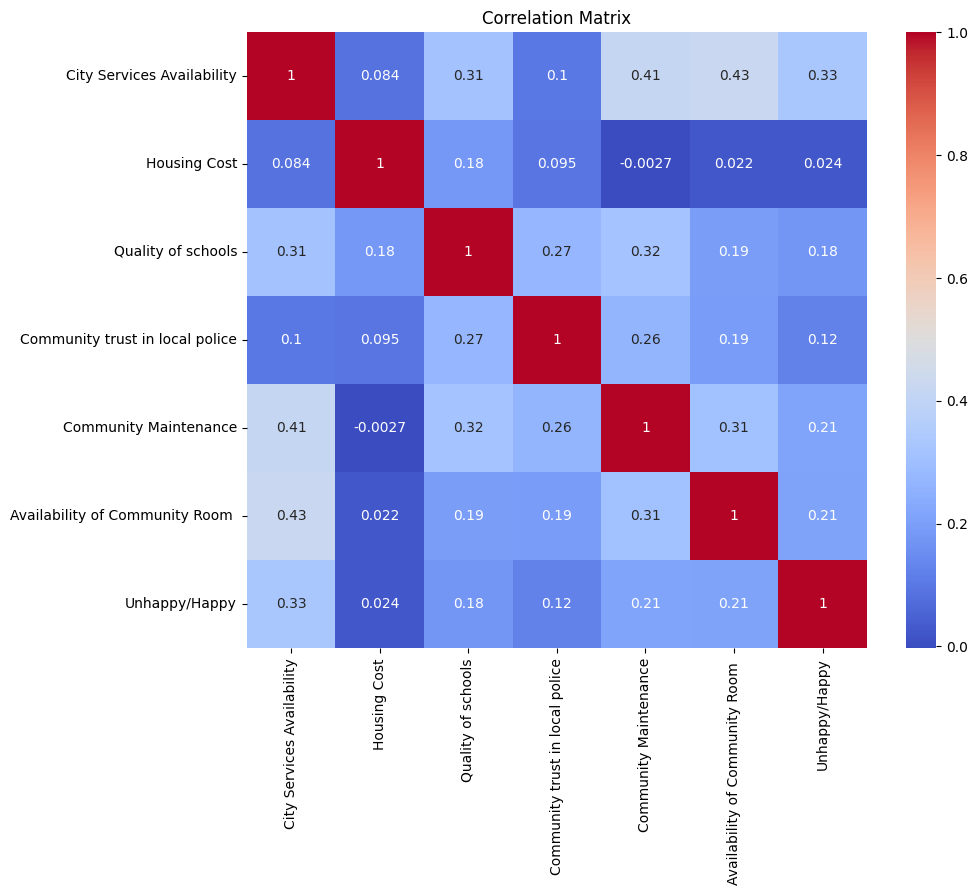

In [5]:
# Correlation matrix
correlation_matrix = df.corr()

# Visualize correlation using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Splitting the Data into Training and Testing Sets

In [6]:
# Separate features (X) from target variable (y)
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Only the last column

# Create train and test sets (80% train, 20% test), uses random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

## Custom Implementation of K-Nearest Neighbor

In [7]:
def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def manhattan_distance(point1, point2):
    """Calculate the Manhattan distance between two points."""
    return np.sum(np.abs(np.array(point1) - np.array(point2)))

def k_nearest_neighbors(X_train, y_train, test_instance, k, distance_function=euclidean_distance):
    """
    Finds the k nearest neighbors of a test instance and predicts its class based on majority voting.
    """
    # Combine features and labels
    training_data = np.column_stack((X_train, y_train))

    # Calculate distances between test instance and all training instances
    distances = []
    for train_instance in training_data:
        features = train_instance[:-1]  # Exclude the class label
        distance = distance_function(test_instance, features)
        distances.append((train_instance, distance))

    # Sort distances in ascending order
    distances.sort(key=lambda x: x[1])

    # Collect k nearest neighbors
    k_neighbors = [instance[0][-1] for instance in distances[:k]]

    # Predict class with majority voting
    prediction = max(set(k_neighbors), key=k_neighbors.count)

    return prediction

## Running my K-Nearest Neighbor algorithm

In [8]:
# Test our custom KNN implementation on the test set
predictions_custom_knn = []

# Go through each test instance and predict the class
for test_instance in X_test.values:
    prediction = k_nearest_neighbors(X_train.values, y_train.values, test_instance, k=5)
    predictions_custom_knn.append(prediction)

# Evaluate performance
print(confusion_matrix(y_test, predictions_custom_knn))

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_custom_knn))

[[8 7]
 [5 8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.53      0.62      0.57        13

    accuracy                           0.57        28
   macro avg       0.57      0.57      0.57        28
weighted avg       0.58      0.57      0.57        28



## Comparing with Scikit-learn KNN Implementation

In [9]:
# Set up and train Scikit-learns KNN classifier
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
knn_sklearn.fit(X_train, y_train)

# Make predictions
y_pred = knn_sklearn.predict(X_test)

# Display model performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[7 8]
 [6 7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        15
           1       0.47      0.54      0.50        13

    accuracy                           0.50        28
   macro avg       0.50      0.50      0.50        28
weighted avg       0.51      0.50      0.50        28



## Finding the Best K (Euclidean Distance / Manhattan Distance) Using the Elbow Plot

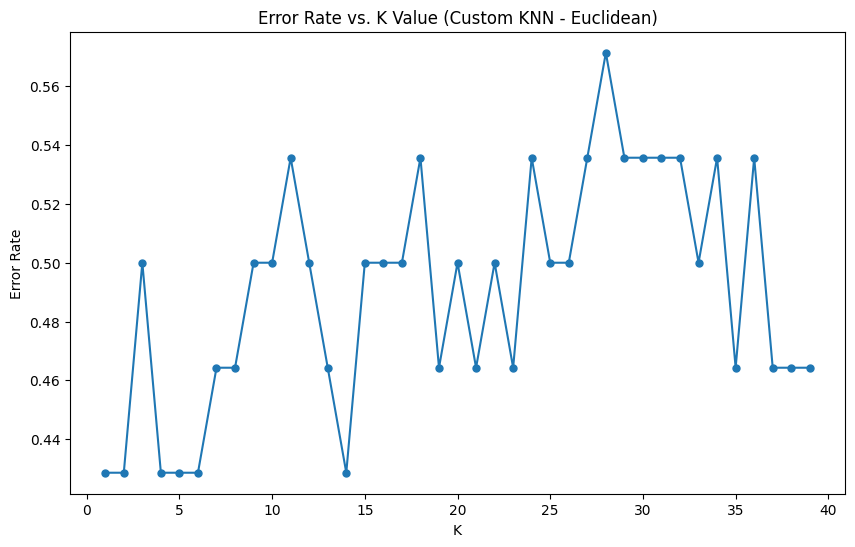

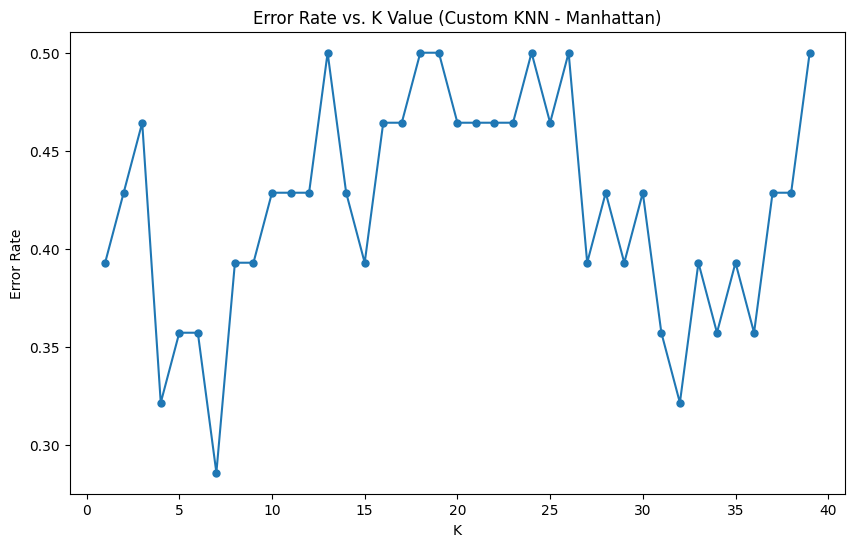

In [10]:
def plot_elbow(X_train, y_train, X_test, y_test, distance_function, title):
    """
    Plot the elbow curve for KNN with varying K values.
    """
    error_rate = []

    for k in range(1, 40):
        predictions_custom_knn = []
        # Make predictions for each test instance
        for test_instance in X_test.values:
            prediction = k_nearest_neighbors(X_train.values, y_train.values, test_instance, k, distance_function=distance_function)
            predictions_custom_knn.append(prediction)
        # Store the error rate for current K
        error_rate.append(np.mean(predictions_custom_knn != y_test.values))

    # Create and customize the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 40), error_rate, marker='o', markersize=5)
    plt.title(f'Error Rate vs. K Value (Custom KNN - {title})')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()


# Plot elbow for Euclidean distance
plot_elbow(X_train, y_train, X_test, y_test, euclidean_distance, "Euclidean")

# Plot elbow for Manhattan distance
plot_elbow(X_train, y_train, X_test, y_test, manhattan_distance, "Manhattan")

Evaluate Time Performances

In [11]:
def evaluate_knn(X_train, y_train, X_test, y_test, distance_function, k=5, method=""):
    # Measure execution time and make predictions
    start_time = time.time()
    predictions_custom_knn = []
    for test_instance in X_test.values:
        prediction = k_nearest_neighbors(X_train.values, y_train.values, test_instance, k, distance_function=distance_function)
        predictions_custom_knn.append(prediction)
    end_time = time.time()

    print(f"{method} ({distance_function.__name__.capitalize()}) took {end_time - start_time:.4f} seconds")
    print(f"Evaluation for {method} ({distance_function.__name__.capitalize()}):")
    print(confusion_matrix(y_test, predictions_custom_knn))
    print(classification_report(y_test, predictions_custom_knn))


def evaluate_sklearn_knn(knn_model, X_test, y_test):
    # Time the prediction process
    start_time = time.time()
    y_pred_sklearn = knn_model.predict(X_test)
    end_time = time.time()

    print(f"Scikit-learn KNN took {end_time - start_time:.4f} seconds")
    print("Evaluation for Scikit-learn KNN:")
    print(confusion_matrix(y_test, y_pred_sklearn))
    print(classification_report(y_test, y_pred_sklearn))

evaluate_knn(X_train, y_train, X_test, y_test, euclidean_distance)
evaluate_knn(X_train, y_train, X_test, y_test, manhattan_distance)
evaluate_sklearn_knn(knn_sklearn, X_test, y_test)

 (Euclidean_distance) took 0.0320 seconds
Evaluation for  (Euclidean_distance):
[[8 7]
 [5 8]]
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.53      0.62      0.57        13

    accuracy                           0.57        28
   macro avg       0.57      0.57      0.57        28
weighted avg       0.58      0.57      0.57        28

 (Manhattan_distance) took 0.0160 seconds
Evaluation for  (Manhattan_distance):
[[ 8  7]
 [ 3 10]]
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.59      0.77      0.67        13

    accuracy                           0.64        28
   macro avg       0.66      0.65      0.64        28
weighted avg       0.66      0.64      0.64        28

Scikit-learn KNN took 0.0000 seconds
Evaluation for Scikit-learn KNN:
[[7 8]
 [6 7]]
              precision    recall  f1-score   support

           0

## Model Evaluation and Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score

# Do 10-fold cross-validation
scores = cross_val_score(knn_sklearn, X, y, cv=10, scoring='accuracy')
print(f'Mean accuracy from cross-validation: {np.mean(scores)}')

Mean accuracy from cross-validation: 0.5203296703296704
